In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem  # RDKit用于计算分子指纹
import os
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Performing grid search
from scipy.stats import skew
from collections import OrderedDict
from sklearn.inspection import permutation_importance
import shap
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import joblib
import numbers
import torch
from torch_geometric.loader import DataLoader  

In [18]:
# 直接加载当前目录下的 style.mplstyle
plt.style.use('~/style.mplstyle')
import matplotlib.pyplot as plt

# 打印当前使用的字体
print("当前字体:", plt.rcParams["font.family"])

当前字体: ['Arial']


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        """
        初始化函数，定义MLP的层次结构，同时引入BatchNorm和Dropout以防止过拟合。

        参数：
        - input_size (int): 输入特征的维度，即每个样本特征向量的长度。
        - hidden_sizes (list of int): 隐藏层的神经元数量列表。
        - output_size (int): 输出层的神经元数量，通常对应于分类任务的类别数或回归任务的目标维度。
        - dropout_rate (float): Dropout比例，用于抑制过拟合，默认值为0.3。
        
        示例：
        如果输入特征维度为20，隐藏层神经元数量为[64, 32]，输出维度为10：
        model = MLP(input_size=20, hidden_sizes=[64, 32], output_size=10, dropout_rate=0.3)
        """
        super(MLP, self).__init__()
        layers = []
        in_dim = input_size  # 当前层输入维度初始为input_size
        
        # 构建隐藏层：每层包含线性映射、BatchNorm、ReLU激活和Dropout
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_dim, hidden_size))            # 线性层
            layers.append(nn.BatchNorm1d(hidden_size))                 # 批归一化层，有助于稳定训练
            layers.append(nn.ReLU())                                   # ReLU激活函数，增加非线性
            layers.append(nn.Dropout(dropout_rate))                    # Dropout层，防止过拟合
            in_dim = hidden_size                                      # 更新下一层的输入维度
        
        # 添加输出层，不使用激活函数（可根据任务需要在损失函数中处理）
        layers.append(nn.Linear(in_dim, output_size))
        
        # 将所有层组合成一个顺序模型
        self.network = nn.Sequential(*layers)

    def forward(self, data):
        """
        前向传播函数，定义数据如何通过模型。

        参数：
        - data: 包含输入数据的对象，其中 data.morgan_fp 是分子指纹，形状为 [batch_size, input_size]

        返回：
        - out (Tensor): 模型的输出，形状为 [batch_size, output_size]
        """
        x = data.morgan_fp  # 以分子指纹作为输入
        out = self.network(x)  # 数据通过网络进行前向传播
        return out

In [20]:
# 加载IL_ECW_xgb_model
IL_ECW_xgb_model_path = '/data/jupyternotebook_public/Project15_AI_ML_BMS_JZZ/cemp/ionic_liquid/static/model/IL_ECW_xgb_model_fp.joblib'
IL_ECW_xgb_model = joblib.load(IL_ECW_xgb_model_path)
print("IL_ECW_xgb_model加载成功！")

# 加载Tm_xgb_model
Tm_xgb_model_path = '/data/jupyternotebook_public/Project15_AI_ML_BMS_JZZ/cemp/ionic_liquid/static/model/Tm_xgb_model_fp.joblib'
Tm_xgb_model = joblib.load(Tm_xgb_model_path)
print("Tm_xgb_model加载成功！")

# 加载model_conductivity_MLP
# MLP模型初始化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 2048
hidden_sizes = [256, 64]
output_size = 1
model_conductivity_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
MLP_model_path = '/data/jupyternotebook_public/Project15_AI_ML_BMS_JZZ/cemp/ionic_liquid/static/model/conductivity_MLP_model_fp.pt'
# 注意：torch.load中指定map_location确保模型加载到CPU上
state_dict = torch.load(MLP_model_path, map_location=device)
model_conductivity_MLP.load_state_dict(state_dict)
print("MLP模型参数加载成功！")

IL_ECW_xgb_model加载成功！
Tm_xgb_model加载成功！
MLP模型参数加载成功！


In [21]:
import torch
# 加载数据集
def load_data_list(file_path):
    """
    从指定文件路径加载数据列表。

    参数：
    file_path (str): 数据列表文件的路径。

    返回：
    list: 加载的数据列表。
    """
    return torch.load(file_path)

############## Tm ##############
Tm_load_file_path = '../dataset/Tm_data_list.pt' # 总数据集
Tm_load_train_dataset_path = '../dataset/train_Tm_data_list.pt' # 训练集
Tm_load_val_dataset_path = '../dataset/val_Tm_data_list.pt' # 验证集
Tm_load_test_dataset_path = '../dataset/test_Tm_data_list.pt' # 验证集

# 加载数据集
Tm_loaded_data_list = load_data_list(Tm_load_file_path)
Tm_loaded_train_data_list = load_data_list(Tm_load_train_dataset_path)
Tm_loaded_val_data_list = load_data_list(Tm_load_val_dataset_path)
Tm_loaded_test_data_list = load_data_list(Tm_load_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(Tm_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(Tm_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(Tm_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(Tm_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
Tm_train_loader = DataLoader(Tm_loaded_train_data_list, batch_size=32, shuffle=True)  
Tm_val_loader = DataLoader(Tm_loaded_val_data_list, batch_size=32, shuffle=False)  
Tm_test_loader = DataLoader(Tm_loaded_test_data_list, batch_size=32, shuffle=False) 


############## conductivity ##############
conductivity_load_file_path = 'conductivity_data_list.pt' # 总数据集
conductivity_load_train_dataset_path = 'train_conductivity_data_list.pt' # 训练集
conductivity_load_val_dataset_path = 'val_conductivity_data_list.pt' # 验证集
conductivity_load_test_dataset_path = 'test_conductivity_data_list.pt' # 验证集

# 加载数据集
conductivity_loaded_data_list = load_data_list(conductivity_load_file_path)
conductivity_loaded_train_data_list = load_data_list(conductivity_load_train_dataset_path)
conductivity_loaded_val_data_list = load_data_list(conductivity_load_val_dataset_path)
conductivity_loaded_test_data_list = load_data_list(conductivity_load_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(conductivity_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(conductivity_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(conductivity_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(conductivity_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
conductivity_train_loader = DataLoader(conductivity_loaded_train_data_list, batch_size=32, shuffle=True)  
conductivity_val_loader = DataLoader(conductivity_loaded_val_data_list, batch_size=32, shuffle=False)  
conductivity_test_loader = DataLoader(conductivity_loaded_test_data_list, batch_size=32, shuffle=False)  

######################离子液体ECW######################
IL_ECW_save_total_dataset_path = '../dataset/IL_ECW_data_list.pt' # 总数据集
IL_ECW_save_train_dataset_path = '../dataset/train_IL_ECW_data_list.pt' # 训练集
IL_ECW_save_val_dataset_path = '../dataset/val_IL_ECW_data_list.pt' # 验证集
IL_ECW_save_test_dataset_path = '../dataset/test_IL_ECW_data_list.pt' # 测试集

# 加载数据集
IL_ECW_loaded_data_list = load_data_list(IL_ECW_save_total_dataset_path)
IL_ECW_loaded_train_data_list = load_data_list(IL_ECW_save_train_dataset_path)
IL_ECW_loaded_val_data_list = load_data_list(IL_ECW_save_val_dataset_path)
IL_ECW_loaded_test_data_list = load_data_list(IL_ECW_save_test_dataset_path)

# 打印加载后数据集的信息
print(f"加载的数据列表大小: {len(IL_ECW_loaded_data_list)}")
print(f"加载的训练数据列表大小: {len(IL_ECW_loaded_train_data_list)}")
print(f"加载的验证数据列表大小: {len(IL_ECW_loaded_val_data_list)}")
print(f"加载的测试数据列表大小: {len(IL_ECW_loaded_test_data_list)}")

# 加载训练集、测试集与验证集
IL_ECW_train_loader = DataLoader(IL_ECW_loaded_train_data_list, batch_size=32, shuffle=True)  
IL_ECW_val_loader = DataLoader(IL_ECW_loaded_val_data_list, batch_size=32, shuffle=False)  
IL_ECW_test_loader = DataLoader(IL_ECW_loaded_test_data_list, batch_size=32, shuffle=False)  

加载的数据列表大小: 1668
加载的训练数据列表大小: 1334
加载的验证数据列表大小: 167
加载的测试数据列表大小: 167
加载的数据列表大小: 549
加载的训练数据列表大小: 439
加载的验证数据列表大小: 55
加载的测试数据列表大小: 55
加载的数据列表大小: 1466
加载的训练数据列表大小: 1172
加载的验证数据列表大小: 147
加载的测试数据列表大小: 147


In [23]:
# 在测试集上对模型进行评估
def testing_mlp(model, test_loader,scale=1, input_type="fp"):
    model.to(device)
    model.eval()

    total_loss = 0
    test_pred = []
    test_true = []
    loss_fn = torch.nn.MSELoss()  # 定义均方误差损失函数

    # 在测试集上进行评估
    for data in test_loader:
        data = data.to(device)
        if input_type=="fp":
            data.morgan_fp = data.morgan_fp.float()  # 将节点特征转换为浮点数
        elif input_type=="2Ddescriptors":
            data.moldescriptor = data.moldescriptor.float()  # 将节点特征转换为浮点数
        out = model(data)
        loss = loss_fn(out, data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
        total_loss += loss.item()
        # 模型输出的预测值已经是在放大后的尺度上
        test_pred.append(out.detach().cpu().numpy())
        # 为了保证尺度一致
        test_true.append(scale*data.y.cpu().numpy())

    test_pred = np.concatenate(test_pred, axis=0)
    test_true = np.concatenate(test_true, axis=0)
    average_loss = total_loss / len(test_loader)

    # 计算测试集上的指标：MSE, MAE 和 R2
    test_pred_flat = test_pred.flatten()  # 扁平化预测结果
    test_true_flat = test_true.flatten()  # 扁平化真实值
    test_mse = mean_squared_error(test_true_flat, test_pred_flat)
    test_mae = mean_absolute_error(test_true_flat, test_pred_flat)
    test_r2 = r2_score(test_true_flat, test_pred_flat)
    return test_pred, test_true, test_mse, test_mae, test_r2

In [24]:
# 在测试集上对模型进行评估
def testing_GNN(model, test_loader,scale=1):
    model.to(device)
    model.eval()

    total_loss = 0
    test_pred = []
    test_true = []
    loss_fn = torch.nn.MSELoss()  # 定义均方误差损失函数

    
    # 在测试集上进行评估
    for data in test_loader:
        data = data.to(device)
        data.x = data.x.float()
        out = model(data)
        loss = loss_fn(out, data.y.view(-1, 1))  # 只取 y 的最后一列作为真值
        total_loss += loss.item()
        test_pred.append(out.detach().cpu().numpy())
        test_true.append(scale*data.y.cpu().numpy())

    test_pred = np.concatenate(test_pred, axis=0)
    test_true = np.concatenate(test_true, axis=0)
    average_loss = total_loss / len(test_loader)

    # 计算测试集上的指标：MSE, MAE 和 R2
    test_pred_flat = test_pred.flatten()  # 扁平化预测结果
    test_true_flat = test_true.flatten()  # 扁平化真实值
    test_mse = mean_squared_error(test_true_flat, test_pred_flat)
    test_mae = mean_absolute_error(test_true_flat, test_pred_flat)
    test_r2 = r2_score(test_true_flat, test_pred_flat)

    print(f"Test Loss: {average_loss:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    
    return test_pred, test_true, test_mse, test_mae, test_r2  # 返回损失和预测结果

In [25]:
'''
请你修改下2段代码，新增输入值（1）散点图的类型（例如可以选择星形，三角形，圆形，散点应该是空心），并且这两段代码使用相同的绘图参数
'''
def plot_targets(pred, ground_truth, mse, mae, save_path="GAT_val.png", figsize=(2.3, 2.3), 
                 marker_style="o", scale_factor=1):
    """
    绘制预测值与真实值的散点图，并在图中显示MAE、MSE和R²。
    
    参数：
        pred (array-like)       -- 模型预测值
        ground_truth (array-like)-- 真实值
        mse (float)             -- 均方误差
        mae (float)             -- 平均绝对误差
        save_path (str)         -- 保存图像路径，默认 "GAT_val.png"
        figsize (tuple)         -- 图像大小，默认 (2.3, 2.3)
        marker_style (str)      -- 散点形状，默认为空心圆 "o"、"^"、"s"、"*" 
        
    返回：
        None
    """
    # 设置字体、字号、边框等全局绘图参数
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 7

    # 对预测值和真实值进行放大处理
    pred_scaled = [p * scale_factor for p in pred]
    ground_truth_scaled = [g * scale_factor for g in ground_truth]

    # 计算 R²（决定系数）
    r2 = r2_score(ground_truth, pred)
    
    # 创建图和轴对象
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制空心散点图
    ax.scatter(pred_scaled, ground_truth_scaled, s=10, marker=marker_style, facecolors='none', edgecolors='grey')
    
    # 添加参考线 y = x
    ax.axline((1, 1), slope=1, color="red", linestyle="--")
    
    # 设置坐标轴标签
    ax.set_xlabel("Predicted Value")
    ax.set_ylabel("Ground Truth")
    
    # 在左上角显示 MAE、MSE、R²
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}"
    ax.text(0.05, 0.95, text_str,
            transform=ax.transAxes,
            fontsize=7, color="black",
            verticalalignment="top", horizontalalignment="left")
    
    # 设置边框宽度
    for spine in ax.spines.values():
        spine.set_linewidth(0.75)
    
    # 保存并显示图像
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def extract_features_targets(data_list, scale=1, feature = "fp"):
    """
    从数据列表中提取moldescriptor作为特征X和y中指定索引的值作为目标Y。
    
    Args:
        data_list (list): 包含Data对象的列表。
        target_index (int): y中要预测的索引位置。
        feature (str): 可选"2Ddescriptors"或“fp”，代表训练模型时使用的特征
        
    Returns:
        X (np.ndarray): 特征矩阵。
        Y (np.ndarray): 目标向量。
    """
    X = []
    Y = []
    for data in data_list:
        # 提取moldescriptor，假设其形状为 [1, 183]
        if feature == "2Ddescriptors":
            moldescriptor = data.moldescriptor.numpy().flatten() # 采用分子描述符作为特征
            X.append(moldescriptor)
            
        elif feature == "fp":
            fp = data.morgan_fp.numpy().flatten() # 采用分子描述符作为特征
            X.append(fp)
            
        # 提取目标y值
        target = data.y.numpy().flatten()
        Y.append(scale*target)
        
    # print(X)
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [ ]:
def evaluate_model(model, val_list, scale=1, figname="model_evaluation",
                   figsize=(2.3, 2.3), output=False, feature="fp", marker_style="o"):
    """
    对模型在验证集上进行评估，并打印出不同的性能指标。然后可视化预测值与真实值的散点图。
    
    参数:
        model -- 已训练的机器学习模型
        val_list -- 验证集列表（包含所有数据）
        target_index (int) -- y中要预测的索引位置，默认为0
        figname (str) -- 保存图像的文件名，不包括扩展名
        figsize (tuple) -- 图像大小，默认为 (2.3, 2.3)
        output (bool) -- 是否保存图像，默认为 False
        feature (str) -- 提取特征的类型，如 "fp"
        marker_style (str) -- 散点形状，默认为空心圆 "o"、"^"、"s"、"*" 等
    
    返回:
        mae, mse, r2 (float, float, float) -- 平均绝对误差、均方误差、决定系数
    """
    # 假设 extract_features_targets 已经定义
    X_test, y_test = extract_features_targets(val_list, scale, feature)
    
    # 设置全局绘图参数
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 7
    
    # 使用模型对测试集进行预测
    y_pred = model.predict(X_test)
    print(y_pred)
    # 计算 MSE、MAE、RMSE、R²
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE (Mean Squared Error): {mse:.2f}")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    
    # 绘制散点图
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(y_pred, y_test, s=10, marker=marker_style, facecolors='none', edgecolors='grey')
    
    # 添加参考线 y = x
    ax.axline((1, 1), slope=1, color="red", linestyle="--")
    
    # 设置坐标轴标签
    ax.set_xlabel("Predicted Value")
    ax.set_ylabel("Ground Truth")
    
    # 在左上角显示 MAE、MSE、R²
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}"
    ax.text(0.05, 0.95, text_str,
            transform=ax.transAxes,
            fontsize=7, color="black",
            verticalalignment="top", horizontalalignment="left",
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # 设置边框宽度
    for spine in ax.spines.values():
        spine.set_linewidth(0.75)
    
    # 保存图片（如果需要）
    if output:
        plt.savefig(f"{figname}.png", dpi=300, bbox_inches="tight")
    
    plt.show()
    return mae, mse, r2

MSE (Mean Squared Error): 1204.67
MAE (Mean Absolute Error): 24.59
RMSE (Root Mean Squared Error): 34.71
R^2 Score: 0.68


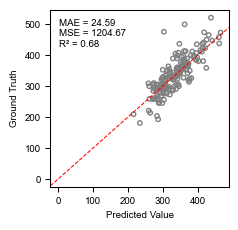

MSE (Mean Squared Error): 0.67
MAE (Mean Absolute Error): 0.43
RMSE (Root Mean Squared Error): 0.82
R^2 Score: 0.77


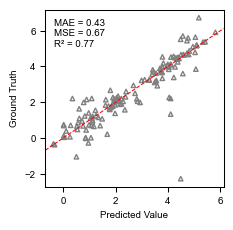

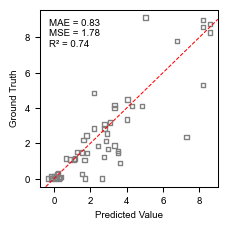

In [ ]:
'''
IL_ECW_xgb_model
Tm_xgb_model
model_conductivity_MLP 
'''
evaluate_model(Tm_xgb_model, Tm_loaded_test_data_list, figname="Tm_xgboost_model_evaluation",
                   figsize=(2.3, 2.3), output=True, feature = "fp", marker_style="o")

evaluate_model(IL_ECW_xgb_model, IL_ECW_loaded_test_data_list, figname="IL_ECW_xgboost_model_evaluation",
               figsize=(2.3, 2.3), output=True, feature = "fp", marker_style="^")
conductivity_test_pred_mlp, conductivity_test_true_mlp, conductivity_test_mse_mlp, conductivity_test_mae_mlp, conductivity_test_r2_mlp = testing_mlp(model_conductivity_MLP , conductivity_test_loader, scale=10, input_type="fp")
plot_targets(conductivity_test_pred_mlp, conductivity_test_true_mlp, conductivity_test_mse_mlp, conductivity_test_mae_mlp, save_path="conductivity_MLP_test.png"
             , marker_style="s")

# 其他模型的预测性能展示

In [45]:
import os   # 导入os模块，用于处理文件路径
import sys  # 导入sys模块，用于修改Python的搜索路径
sys.path.insert(0, "/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties")  # 插入到索引0，确保导入时优先查找父目录

from GATModel import GAT
from GCNModel import GCN
from MLPModel import MLP

In [46]:
# 设置设备为GPU（如果可用），否则使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GAT
model_Tm_GAT = GAT(in_channels=5,hidden_channels=256).to(device)  
model_conductivity_GAT = GAT(in_channels=5,hidden_channels=256).to(device)  
model_IL_ECW_GAT = GAT(in_channels=5,hidden_channels=256).to(device) 
# GCN
model_Tm_GCN = GCN(hidden_dim=128).to(device)
model_conductivity_GCN = GCN(hidden_dim=128).to(device) 
model_IL_ECW_GCN = GCN(hidden_dim=128).to(device) 
# MLP
input_size = 2048
hidden_sizes = [256, 64]
output_size = 1
model_Tm_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_conductivity_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_IL_ECW_MLP = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 

In [47]:
# 加载电导率预测模型
MLP_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/conductivity_MLP_model.pt'
GCN_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/conductivity_GCN_model.pt'
GAT_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/conductivity_GAT_model.pt'

MLP_state_dict = torch.load(MLP_model_path, map_location=device)
GCN_state_dict = torch.load(GCN_model_path, map_location=device)
GAT_state_dict = torch.load(GAT_model_path, map_location=device)

model_conductivity_MLP.load_state_dict(MLP_state_dict)
model_conductivity_GCN.load_state_dict(GCN_state_dict)
model_conductivity_GAT.load_state_dict(GAT_state_dict)
print("conductivity模型参数加载成功！")

# 加载conductivity_xgb_model
conductivity_xgb_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/conductivity_xgb_model.joblib'
conductivity_xgb_model = joblib.load(conductivity_xgb_model_path)
print("conductivity_xgb_model加载成功！")

# 加载Tm预测模型
MLP_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/Tm_MLP_model.pt'
GCN_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/Tm_GCN_model.pt'
GAT_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/Tm_GAT_model.pt'

MLP_state_dict = torch.load(MLP_model_path, map_location=device)
GCN_state_dict = torch.load(GCN_model_path, map_location=device)
GAT_state_dict = torch.load(GAT_model_path, map_location=device)

model_Tm_MLP.load_state_dict(MLP_state_dict)
model_Tm_GCN.load_state_dict(GCN_state_dict)
model_Tm_GAT.load_state_dict(GAT_state_dict)
print("Tm模型参数加载成功！")

# 加载Tm_xgb_model
Tm_xgb_model_path = '/data/jupyternotebook_public/Project15_AI_ML_BMS_JZZ/cemp/ionic_liquid/static/model/Tm_xgb_model_fp.joblib'
Tm_xgb_model = joblib.load(Tm_xgb_model_path)
print("Tm_xgb_model加载成功！")


# 加载ECW预测模型
MLP_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/IL_ECW_MLP_model.pt'
GCN_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/IL_ECW_GCN_model.pt'
GAT_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/IL_ECW_GAT_model.pt'

MLP_state_dict = torch.load(MLP_model_path, map_location=device)
GCN_state_dict = torch.load(GCN_model_path, map_location=device)
GAT_state_dict = torch.load(GAT_model_path, map_location=device)

model_IL_ECW_MLP.load_state_dict(MLP_state_dict)
model_IL_ECW_GCN.load_state_dict(GCN_state_dict)
model_IL_ECW_GAT.load_state_dict(GAT_state_dict)
print("ECW模型参数加载成功！")

# 加载conductivity_xgb_model
IL_ECW_xgb_model_path = '/data/jupyternotebook_public/jifengwang/17_HTQC_analysis/AI_prediction_properties/predict_Tm_conductivity/IL_ECW_xgb_model.joblib'
IL_ECW_xgb_model = joblib.load(IL_ECW_xgb_model_path)
print("IL_ECW_xgb_model加载成功！")


conductivity模型参数加载成功！
conductivity_xgb_model加载成功！
Tm模型参数加载成功！
Tm_xgb_model加载成功！
ECW模型参数加载成功！
IL_ECW_xgb_model加载成功！


Test Loss: 2061.4351, MSE: 2000.4821, MAE: 33.9557, R2: 0.4673


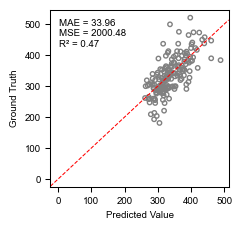

Test Loss: 1.3122, MSE: 1.3343, MAE: 0.9154, R2: 0.5478


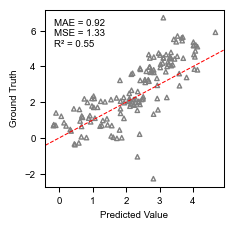

Test Loss: 8.1224, MSE: 2.1481, MAE: 1.0476, R2: 0.6826


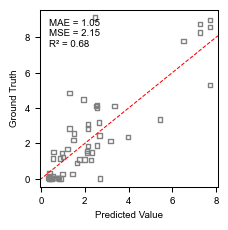

In [38]:
# GCN模型评估
Tm_test_pred, Tm_test_true, Tm_test_mse, Tm_test_mae, Tm_test_r2_mlp = testing_GNN(model_Tm_GCN , Tm_test_loader)
plot_targets(Tm_test_pred, Tm_test_true, Tm_test_mse, Tm_test_mae, save_path="Tm_GCN_test.png"
             , marker_style="o")

IL_ECW_test_pred, IL_ECW_test_true, IL_ECW_test_mse, IL_ECW_test_mae, IL_ECW_test_r2 = testing_GNN(model_IL_ECW_GCN , IL_ECW_test_loader)
plot_targets(IL_ECW_test_pred, IL_ECW_test_true, IL_ECW_test_mse, IL_ECW_test_mae, save_path="IL_ECW_GCN_test.png"
             , marker_style="^")

conductivity_test_pred, conductivity_test_true, conductivity_test_mse, conductivity_test_mae, conductivity_test_r2 = testing_GNN(model_conductivity_GCN , conductivity_test_loader, scale=10)
plot_targets(conductivity_test_pred, conductivity_test_true, conductivity_test_mse, conductivity_test_mae, save_path="conductivity_GCN_test.png"
             , marker_style="s")

Test Loss: 3046.8991, MSE: 2684.8130, MAE: 40.0981, R2: 0.2850


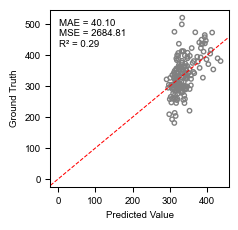

Test Loss: 1.2045, MSE: 1.2540, MAE: 0.8118, R2: 0.5750


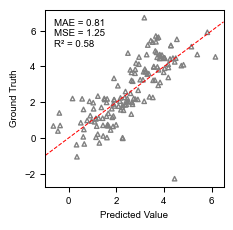

Test Loss: 0.0476, MSE: 0.0456, MAE: 0.1501, R2: 0.3264


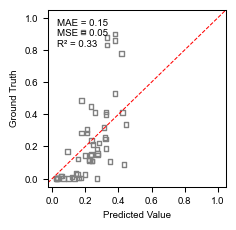

In [16]:
# GAT模型评估
Tm_test_pred, Tm_test_true, Tm_test_mse, Tm_test_mae, Tm_test_r2_mlp = testing_GNN(model_Tm_GAT , Tm_test_loader)
plot_targets(Tm_test_pred, Tm_test_true, Tm_test_mse, Tm_test_mae, save_path="Tm_GAT_test.png"
             , marker_style="o")

IL_ECW_test_pred, IL_ECW_test_true, IL_ECW_test_mse, IL_ECW_test_mae, IL_ECW_test_r2 = testing_GNN(model_IL_ECW_GAT , IL_ECW_test_loader)
plot_targets(IL_ECW_test_pred, IL_ECW_test_true, IL_ECW_test_mse, IL_ECW_test_mae, save_path="IL_ECW_GAT_test.png"
             , marker_style="^")

conductivity_test_pred, conductivity_test_true, conductivity_test_mse, conductivity_test_mae, conductivity_test_r2 = testing_GNN(model_conductivity_GAT , conductivity_test_loader)
plot_targets(conductivity_test_pred, conductivity_test_true, conductivity_test_mse, conductivity_test_mae, save_path="conductivity_GAT_test.png"
             , marker_style="s")

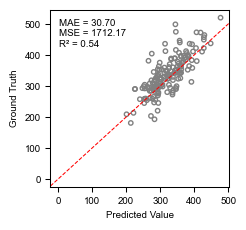

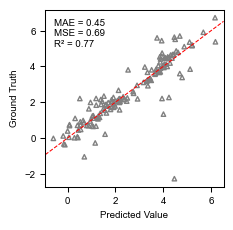

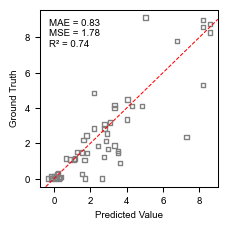

In [35]:
# MLP模型评估
Tm_test_pred, Tm_test_true, Tm_test_mse, Tm_test_mae, Tm_test_r2_mlp = testing_mlp(model_Tm_MLP , Tm_test_loader)
plot_targets(Tm_test_pred, Tm_test_true, Tm_test_mse, Tm_test_mae, save_path="Tm_MLP_test.png"
             , marker_style="o")

IL_ECW_test_pred, IL_ECW_test_true, IL_ECW_test_mse, IL_ECW_test_mae, IL_ECW_test_r2 = testing_mlp(model_IL_ECW_MLP , IL_ECW_test_loader)
plot_targets(IL_ECW_test_pred, IL_ECW_test_true, IL_ECW_test_mse, IL_ECW_test_mae, save_path="IL_ECW_MLP_test.png"
             , marker_style="^")

conductivity_test_pred, conductivity_test_true, conductivity_test_mse, conductivity_test_mae, conductivity_test_r2 = testing_mlp(model_conductivity_MLP , conductivity_test_loader, scale=10)
plot_targets(conductivity_test_pred, conductivity_test_true, conductivity_test_mse, conductivity_test_mae, save_path="conductivity_MLP_test.png"
             , marker_style="s")

MSE (Mean Squared Error): 1204.67
MAE (Mean Absolute Error): 24.59
RMSE (Root Mean Squared Error): 34.71
R^2 Score: 0.68


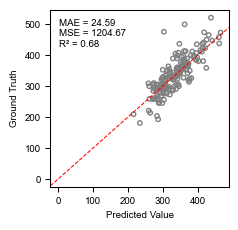

MSE (Mean Squared Error): 0.67
MAE (Mean Absolute Error): 0.43
RMSE (Root Mean Squared Error): 0.82
R^2 Score: 0.77


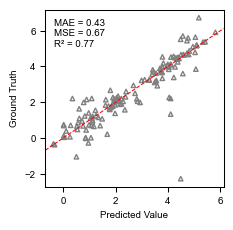

MSE (Mean Squared Error): 0.03
MAE (Mean Absolute Error): 0.12
RMSE (Root Mean Squared Error): 0.17
R^2 Score: 0.59


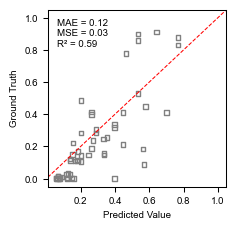

(0.124685585, 0.027770543, 0.589631153606178)

In [ ]:
evaluate_model(Tm_xgb_model, Tm_loaded_test_data_list, scale=1, figname="Tm_xgboost_model_evaluation",
                   figsize=(2.3, 2.3), output=True, feature = "fp", marker_style="o")

evaluate_model(IL_ECW_xgb_model, IL_ECW_loaded_test_data_list, scale=1, figname="IL_ECW_xgboost_model_evaluation",
               figsize=(2.3, 2.3), output=True, feature = "fp", marker_style="^")



[[1.51017809e+00]
 [8.79333019e-01]
 [1.55871615e-01]
 [1.14248848e+00]
 [1.88999998e-04]
 [4.10117149e+00]
 [8.28567985e-03]
 [6.35999953e-04]
 [1.08380008e+00]
 [1.09463882e+00]
 [2.52687573e-01]
 [4.15480995e+00]
 [1.06769037e+00]
 [1.85815334e+00]
 [2.84848833e+00]
 [4.12040806e+00]
 [9.11679077e+00]
 [2.83910751e+00]
 [5.38438112e-02]
 [2.24591605e-02]
 [4.85423899e+00]
 [2.36783242e+00]
 [1.08583055e-01]
 [5.29839993e+00]
 [1.68249631e+00]
 [1.46590066e+00]
 [1.23392630e+00]
 [2.55279565e+00]
 [2.45180845e+00]
 [2.52119713e-02]
 [1.47196865e+00]
 [1.67105362e-01]
 [1.10999997e-06]
 [3.17437410e+00]
 [8.59251785e+00]
 [2.68541336e-01]
 [1.88247550e+00]
 [7.78537655e+00]
 [2.20495296e+00]
 [4.24894616e-02]
 [1.13521016e+00]
 [4.81215417e-02]
 [3.35630202e+00]
 [1.56868553e+00]
 [1.44400406e+00]
 [4.48587513e+00]
 [8.99602699e+00]
 [4.62241005e-03]
 [8.76493549e+00]
 [3.98910284e+00]
 [8.28820324e+00]
 [2.13423085e+00]
 [1.77844912e-02]
 [3.05904150e+00]
 [3.16670477e-01]]
MSE (Mean

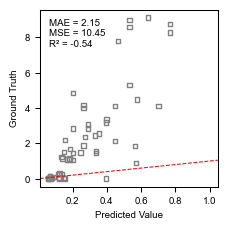

(2.1481295, 10.449828, -0.5441841285514011)

In [43]:
evaluate_model(conductivity_xgb_model, conductivity_loaded_test_data_list, scale=10, figname="conductivity_xgboost_model_evaluation",
               figsize=(2.3, 2.3), output=True, feature = "fp", marker_style="s")